In [1]:
import itertools
import os
import random
import shutil
from PIL import Image

import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt

from sklearn.metrics import classification_report

In [2]:
a = ord('А')
tokens = {chr(letter):i for i,letter in enumerate(range(a, a+32))}
tokens['Ё'] = 32
inv_tokens = {tokens[key]:key for key in tokens}

In [6]:
def DataPrepare(path, test_size = 0.1):
    if os.path.exists("./Train"):
        shutil.rmtree('./Train')
    if os.path.exists("./Test"):
        shutil.rmtree('./Test')
    
    os.mkdir('Train')
    os.mkdir('Test')
    
    
    for letter in tqdm(os.listdir(path)):
        os.mkdir(os.path.join('./Train', letter))
        os.mkdir(os.path.join('./Test', letter))
        if len(letter) == 1:
            imgs = os.listdir(os.path.join(path,letter))
            test_sample = random.sample(imgs, k = int(len(imgs) * test_size))
            for img in imgs:
                if img in test_sample:
                    shutil.copy(os.path.join(path,letter,img), os.path.join('./Test',letter,img))
                else:
                    shutil.copy(os.path.join(path,letter,img), os.path.join('./Train',letter,img))

In [7]:
# DataPrepare('Cyrillic')

In [8]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

class AddPixelNoise(object):
    def __init__(self, p = 0.1):
        self.p = p
        
    def __call__(self, tensor):
        sizes = tensor.size()
        tensor = tensor.view(-1)
        pixels = torch.tensor(random.sample([i for i in range(tensor.size(0))], k = int(tensor.size(0) * self.p)))
        tensor[pixels] = 1
        return tensor.view(sizes)

In [313]:
class DataSet_np():
    def __init__(self, path, train_mode = True):
        self.data = []
        self.train_mode = train_mode
        for letter in os.listdir(path):
            if len(letter) == 1:
                for img in os.listdir(os.path.join(path,letter)):
                    if img == ".ipynb_checkpoints":
                        continue
                    self.data.append([os.path.join(path,letter,img), tokens[letter]])
        random.shuffle(self.data)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        img, target = self.data[index]
        img = Image.open(img)
        if self.train_mode:
            img = img.resize((28,28))
            img = np.array(img)[:,:,3]
        else:
            img = img.resize((28,28))
            img = np.array(img)[:,:,3]
        img[img>0] = 1
        img = img.flatten()
        return img, np.array(target)

In [314]:
train_set = DataSet_np("./Train", train_mode=True)
val_set = DataSet_np("./Test", train_mode=False)

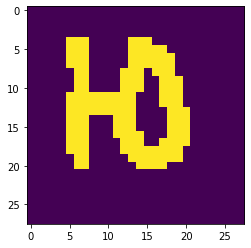

In [315]:
plt.imshow(train_set[100][0].reshape(28,28));

In [316]:
print(len(train_set))
print(len(val_set))

13726
1507


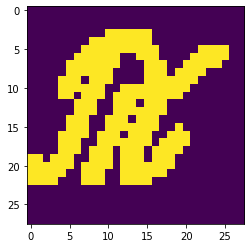

In [317]:
plt.imshow(val_set[100][0].reshape(28,28))

In [318]:
class Fully_Connected:
    def __init__(self, in_size, out_size):
        self.W = np.random.normal(scale=1, size=(out_size, in_size))*np.sqrt(2/(out_size + in_size))
        self.b = np.zeros(out_size)
        
    def forward(self, x):
        self.x = x
#         print('Fully_Connected',x.shape)
        return np.dot(self.W, x) + self.b
    
    def backward(self, dz, lr):
        dx = np.matmul(dz, self.W)
        db = dz
        dW = np.outer(dz, self.x)
        
        self.W = self.W - dW * lr
        self.b = self.b - db * lr
        return dx  

In [319]:
class ReLU:
    def __init__(self):
        pass
    
    def forward(self, x):
        self.x = x
        x[x < 0] = 0
        return x
    
    def backward(self, dz, lr):
        dz[self.x < 0] = 0
        return dz

In [320]:
class Net():
    def __init__(self):
        self.l1 = Fully_Connected(784, 256)
        self.r1 = ReLU()
        
        self.l2 = Fully_Connected(256, 128)
        self.r2 = ReLU()
        
        self.l3 = Fully_Connected(128, 33)
        
    def forward(self, x):
        x = self.r1.forward(self.l1.forward(x))
        x = self.r2.forward(self.l2.forward(x))
        x = self.l3.forward(x)
        return x
    
    def backward(self, dz, lr):
        dz = self.l3.backward(dz, lr)
        dz = self.r2.backward(dz, lr)
        dz = self.l2.backward(dz, lr)
        dz = self.r1.backward(dz, lr)
        dz = self.l1.backward(dz, lr)
        return dz

In [321]:
class SoftMax:
    def __init__(self):
        pass
    
    def forward(self, x):
        self.x = x
        exps = np.exp(x)
        return exps/sum(exps)
    
    def backward(self, dz, lr = 0.1):
        sm = self.forward(self.x)
        lp = (np.eye(sm.shape[0], sm.shape[0]) - sm).T
        lp2 = sm * lp
        return np.dot(dz, lp2)

In [330]:
class CrossEntropy():
    def __init__(self):
        pass
    
    def forward(self, x, y):
        self.x = x[y]
        self.y = y
        self.size = x.shape
        return - np.log(x[y])
    
    def backward(self, lr):
        dz = np.zeros(self.size)
        dz[self.y] = - 1 / self.x
        return dz

In [331]:
net = Net()
softmax = SoftMax()
criterion = CrossEntropy()

In [332]:
# net.forward(np.random.rand(784))

In [333]:
# net.backward(np.random.rand(33), 0.1)

In [334]:
# for i in range(1000):
#     out = net.forward(x)
#     out = softmax.forward(out)
#     loss = criterion.forward(out, y)
#     print(loss)
#     dz = criterion.backward(0.001)
#     dz = softmax.backward(dz, lr = 0.001)
#     dz = net.backward(dz, lr = 0.001)

In [335]:
def train(net, loader, lr):
    mean_loss = []
    
    for img, y in tqdm(loader):
        out = net.forward(x)
        out = softmax.forward(out)
        loss = criterion.forward(out, y)
        
        mean_loss.append(loss)
        
        dz = criterion.backward(lr)
        dz = softmax.backward(dz, lr = lr)
        dz = net.backward(dz, lr = lr)
        
    print("Train loss", sum(mean_loss)/len(mean_loss))

In [336]:
def val(net, loader):   
    mean_loss = []
    
    pred = []
    true = []
    
    for img, y in tqdm(loader):
        out = net.forward(x)
        out = softmax.forward(out)
        
        loss = criterion.forward(out, y)
        
        mean_loss.append(loss)
        
        pred.append(out.argmax())
        true.append(y)
        
    print("Val loss", sum(mean_loss)/len(mean_loss))
    print(classification_report(pred, true))

In [ ]:
%%time
learcning_rate = 0.01
for epoch in range(1, 12):
    if epoch == 6:
        learcning_rate = 0.001
    print("Epoch:",epoch)

    train(net, train_set, learcning_rate)
    val(net, val_set)

  0%|                                                                              | 15/13726 [00:00<01:33, 146.79it/s]

Epoch: 1


  3%|██▌                                                                            | 50/1507 [00:00<00:02, 492.33it/s]

Train loss 3.5228313058378706


100%|█████████████████████████████████████████████████████████████████████████████| 1507/1507 [00:03<00:00, 471.68it/s]
c:\users\zheny\documents\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\zheny\documents\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\zheny\documents\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this 

Val loss 3.5014949780381603
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         0

  6%|████▌                                                                          | 88/1507 [00:00<00:03, 423.21it/s]

Train loss 3.5026236807180897


100%|█████████████████████████████████████████████████████████████████████████████| 1507/1507 [00:03<00:00, 488.64it/s]
c:\users\zheny\documents\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\zheny\documents\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\zheny\documents\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this 

Val loss 3.5021043857447745
              precision    recall  f1-score   support

           0       1.00      0.03      0.06      1507
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         0

 35%|██████████████████████████▏                                                 | 4738/13726 [00:30<01:04, 139.55it/s]

In [25]:
def predict(net, path):
    
    img = Image.open(path).convert("L").resize((28,28))
    img = test_transforms(img)
    img = torch.abs(img - 1)
    img[img > 0] = 1
#     print(img)
    plt.imshow(img[0])
    plt.show()
    img = img.view(-1)
    
    net = net.cpu()
    net.eval()
    with torch.no_grad():
        out = net(img.unsqueeze(0))
        out = out.squeeze(0)
        out = F.softmax(out, dim = -1)
        for key in tokens:
            print(key, out[tokens[key]])
        pred = out.argmax().item()
        print(f'predicted letter is {inv_tokens[pred]}')

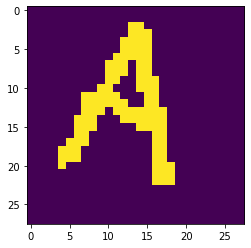

А tensor(0.9511)
Б tensor(1.8005e-10)
В tensor(1.5191e-10)
Г tensor(2.1296e-09)
Д tensor(0.0007)
Е tensor(7.1601e-12)
Ж tensor(1.0281e-08)
З tensor(5.7959e-08)
И tensor(6.5267e-05)
Й tensor(1.8406e-06)
К tensor(3.3220e-07)
Л tensor(0.0462)
М tensor(0.0014)
Н tensor(2.1043e-06)
О tensor(3.1289e-11)
П tensor(2.7955e-07)
Р tensor(2.3198e-08)
С tensor(2.6474e-11)
Т tensor(6.6764e-09)
У tensor(9.0270e-08)
Ф tensor(1.0065e-08)
Х tensor(0.0001)
Ц tensor(8.8790e-09)
Ч tensor(4.2149e-09)
Ш tensor(1.1275e-12)
Щ tensor(1.2968e-10)
Ъ tensor(5.6146e-12)
Ы tensor(6.5381e-11)
Ь tensor(1.6184e-09)
Э tensor(8.6438e-11)
Ю tensor(2.0236e-11)
Я tensor(0.0003)
Ё tensor(2.7987e-12)
predicted letter is А


In [26]:
predict(net, './test2.png')

In [27]:
def showImg(img):
    plt.imshow(img)
    plt.show()

(213, 375, 3)


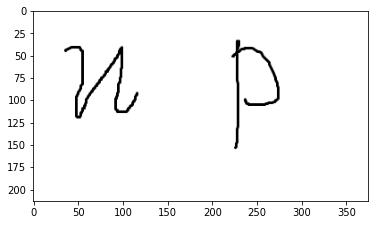

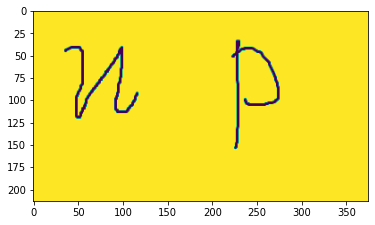

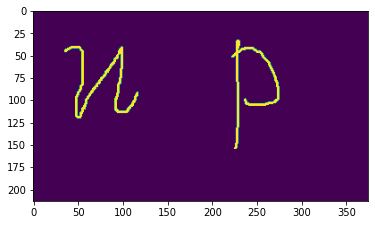

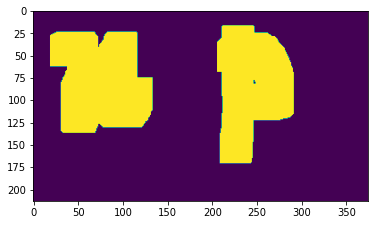

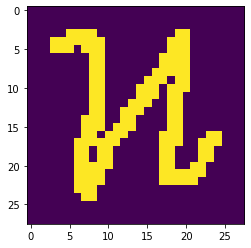

А tensor(2.2281e-10)
Б tensor(1.0610e-09)
В tensor(2.2196e-11)
Г tensor(1.1194e-08)
Д tensor(5.3367e-09)
Е tensor(2.8424e-12)
Ж tensor(0.0001)
З tensor(8.3972e-11)
И tensor(0.9990)
Й tensor(3.3647e-05)
К tensor(6.9434e-05)
Л tensor(5.6316e-07)
М tensor(5.5270e-06)
Н tensor(0.0001)
О tensor(3.8897e-09)
П tensor(8.6138e-05)
Р tensor(1.6184e-07)
С tensor(7.1230e-11)
Т tensor(3.1097e-07)
У tensor(0.0004)
Ф tensor(2.7180e-09)
Х tensor(1.9760e-05)
Ц tensor(3.0865e-06)
Ч tensor(5.5838e-05)
Ш tensor(1.7093e-06)
Щ tensor(1.0827e-07)
Ъ tensor(1.3454e-07)
Ы tensor(7.6751e-06)
Ь tensor(1.4603e-10)
Э tensor(6.6242e-11)
Ю tensor(4.8406e-05)
Я tensor(7.5015e-09)
Ё tensor(4.7127e-13)
predicted letter is И


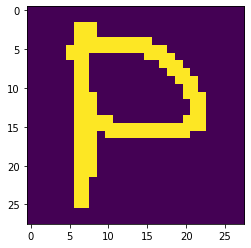

А tensor(4.5293e-05)
Б tensor(0.0012)
В tensor(0.0002)
Г tensor(0.0049)
Д tensor(0.1080)
Е tensor(2.8365e-05)
Ж tensor(8.6851e-06)
З tensor(4.2725e-09)
И tensor(4.0952e-10)
Й tensor(4.8294e-06)
К tensor(0.0150)
Л tensor(1.3594e-06)
М tensor(2.4373e-09)
Н tensor(0.0003)
О tensor(5.4700e-05)
П tensor(0.0003)
Р tensor(0.7529)
С tensor(2.0012e-05)
Т tensor(4.9364e-07)
У tensor(2.0030e-10)
Ф tensor(2.0331e-05)
Х tensor(0.0003)
Ц tensor(2.9051e-09)
Ч tensor(6.6906e-10)
Ш tensor(6.9235e-09)
Щ tensor(9.2319e-11)
Ъ tensor(2.9319e-07)
Ы tensor(1.8699e-06)
Ь tensor(7.4555e-07)
Э tensor(1.0416e-08)
Ю tensor(0.1166)
Я tensor(3.7031e-07)
Ё tensor(1.1236e-06)
predicted letter is Р


In [35]:
import cv2


image = cv2.imread('real_test7.png')
print(image.shape)
showImg(image)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
showImg(gray)
# blur = cv2.GaussianBlur(gray, (9,9), 0)
thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,11,30)

showImg(thresh)

# Dilate to combine adjacent text contours
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9,9))
dilate = cv2.dilate(thresh, kernel, iterations=4)

showImg(dilate)

# Find contours, highlight text areas, and extract ROIs
cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

ROI_number = 0
for c in cnts:
    area = cv2.contourArea(c)
    if area > 1000:
        x,y,w,h = cv2.boundingRect(c)
#         cv2.rectangle(image, (x, y), (x + w, y + h), (36,255,12), 3)
        ROI = image[y:y+h, x:x+w]
        cv2.imwrite(f'ROI_{ROI_number}.png', ROI)
        ROI_number += 1

        predict(net, f'ROI_{ROI_number - 1}.png')